## Predicting Top 50 S&P 500 Stock Market Prices using LSTM

This project aims to predict Top 50 S&P 500 Stock Market Prices using Long-Short Term Memory (LSTM). The dataset was collected from YahooFinance API ranging from 2015-2020. For the data collection, cleaning and exploratory data analysis, this can be viewed in the separate notebook entitled 'EDA - Predicting Top 50 S&P 500 Stock Market Prices' under the same repository. 

As a proof of concept, our dataset will be ranging from January 1, 2015 to December 30, 2020 and we will be predicting the Closing Price on December 31, 2020 for the company Apple (AAPL).

As a limitation, on top of the volatile nature of stock market, the price predictions in this project are only based on previous closing prices and does not include external factors such as macroeconomy, political climate, and company performance etc.

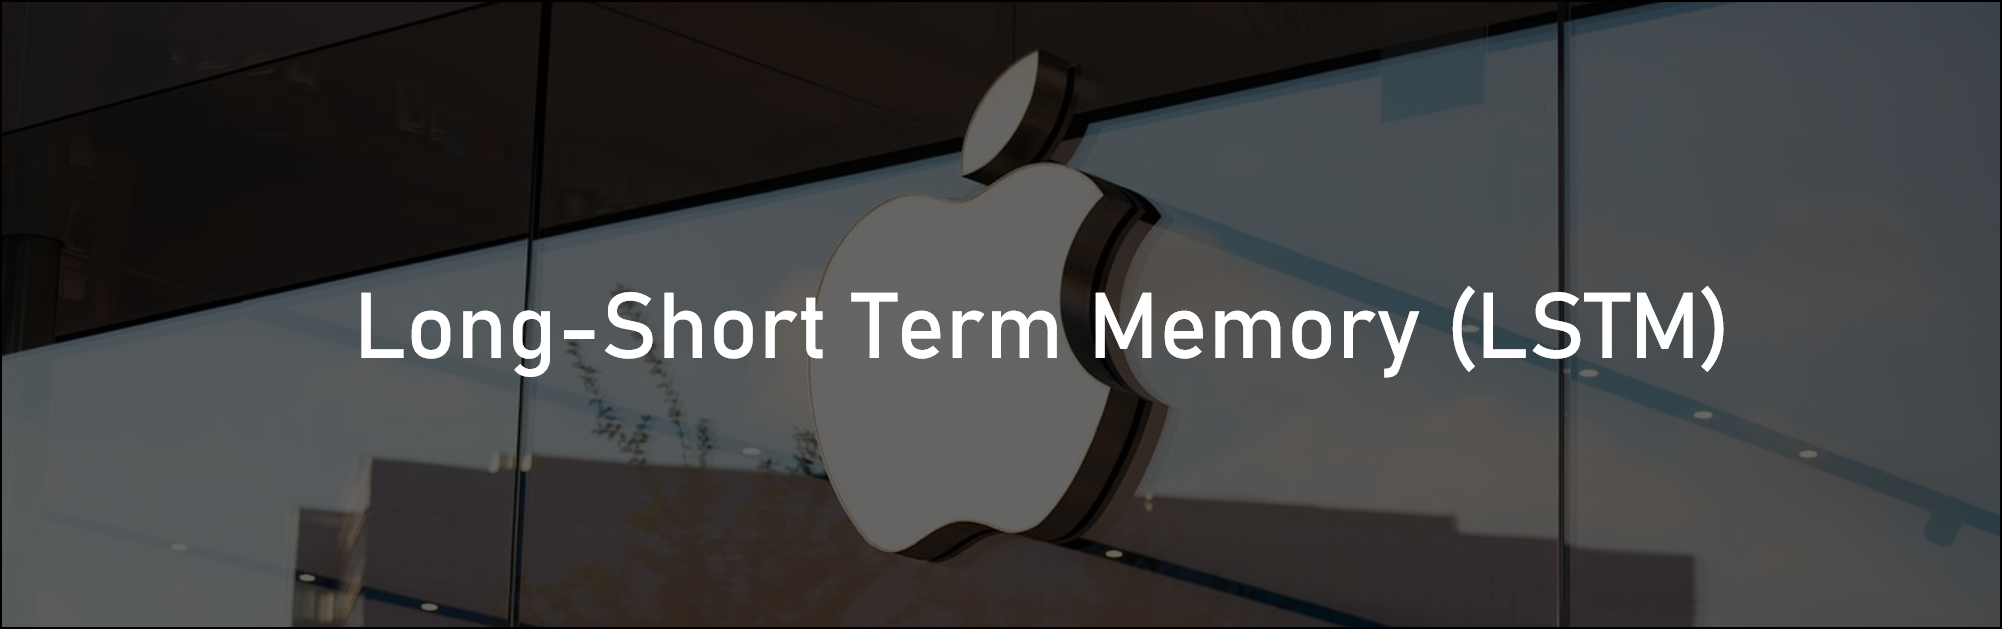

 - Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning.
 - LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is because LSTM is able to store past information that is important, and forget the information that is not.

### Import necessary libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For calculation and web scrape
import math
import pandas_datareader as web

# Import seed for reproducibility
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

#Import Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# For preprocessing and model building
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# date formatting
from datetime import datetime

# Finance data
import yfinance as yf

# Style settings
sns.set()
plt.style.use('seaborn-white')

### Load the Dataset

In [2]:
# Load the datas
df = pd.read_csv('../Stock_Price_Project/Datasets/top_50_final_eda.csv')
df.head()

,Symbol,GICS Sector,Company,Rank,Beta,Dividend Rate,Dividend Yield,Market Cap
0,AAPL,Information Technology,Apple Inc.,1.0,1.283613,0.82,0.0059,2256.00
1,MSFT,Information Technology,Microsoft Corp.,2.0,0.826155,2.24,0.0099,1682.00
2,AMZN,Consumer Discretionary,Amazon.com Inc.,3.0,1.198004,NaN,NaN,1634.00
3,FB,Communication Services,Facebook Inc. Class A,4.0,1.182773,NaN,NaN,778.04
4,TSLA,Consumer Discretionary,Tesla,5.0,2.190651,NaN,NaN,668.91


### List of Top 50 S&P 500 companies

In [3]:
# As of December 3, 2020, the following are the fifty largest S&P 500 index constituents by weight:

stock_list = list(df['Symbol'])
stock_list

['AAPL',
 'MSFT',
 'AMZN',
 'FB',
 'TSLA',
 'GOOGL',
 'GOOG',
 'JNJ',
 'JPM',
 'V',
 'PG',
 'UNH',
 'DIS',
 'NVDA',
 'MA',
 'HD',
 'PYPL',
 'VZ',
 'ADBE',
 'CMCSA',
 'NFLX',
 'BAC',
 'KO',
 'MRK',
 'PEP',
 'T',
 'PFE',
 'INTC',
 'CRM',
 'WMT',
 'ABT',
 'ABBV',
 'CSCO',
 'TMO',
 'NKE',
 'AVGO',
 'XOM',
 'QCOM',
 'COST',
 'ACN',
 'CVX',
 'MCD',
 'MDT',
 'NEE',
 'TXN',
 'HON',
 'DHR',
 'UNP',
 'BMY']

### Collect data from YahooFinance ranging from January 1, 2015 to December 30, 2020

In [4]:
# https://pypi.org/project/yfinance/

# if date today is to be used as end date:
# date_today = datetime.today().strftime('%Y-%m-%d')

sp500 = yf.download(  
        tickers = stock_list,

        interval = "1d",
        group_by = 'ticker',
        auto_adjust = True,
        prepost = True,
        threads = True,
        proxy = None,
        start = '2015-01-01', 
        end = '2020-12-31' #Does not include Dec. 31 in the dataset
    )

[*********************100%***********************]  49 of 49 completed


In [5]:
sp500

AAPL                                                 \
                  Open        High         Low       Close     Volume   
Date                                                                    
2014-12-31   25.693357   25.763955   25.098961   25.137676  165613600   
2015-01-02   25.367691   25.379078   24.447631   24.898552  212818400   
2015-01-05   24.661702   24.743687   24.005818   24.197117  257142000   
2015-01-06   24.263166   24.465853   23.828187   24.199400  263188400   
2015-01-07   24.413472   24.641210   24.299604   24.538729  160423600   
...                ...         ...         ...         ...        ...   
2020-12-23  132.160004  132.429993  130.779999  130.960007   88223700   
2020-12-24  131.320007  133.460007  131.100006  131.970001   54930100   
2020-12-28  133.990005  137.339996  133.509995  136.690002  124486200   
2020-12-29  138.050003  138.789993  134.339996  134.869995  121047300   
2020-12-30  135.580002  135.990005  133.399994  133.720001   96452100   

                  NEE                                             ...  \
                 Open       High        Low      Close    Volume  ...   
Date                                                              ...   
2014-12-31  21.260772  21.382995  20.931560  20.953245   5991200  ...   
2015-01-02  21.020268  21.118834  20.773852  21.032097   6459200  ...   
2015-01-05  21.010414  21.047868  20.736399  20.809338   8153600  ...   
2015-01-06  20.880302  21.272598  20.848762  20.890160  10623200  ...   
2015-01-07  21.209516  21.282456  20.909875  21.081381   7292000  ...   
...               ...        ...        ...        ...       ...  ...   
2020-12-23  75.160004  75.550003  74.330002  74.330002   4626400  ...   
2020-12-24  74.449997  75.160004  74.160004  74.980003   1387500  ...   
2020-12-28  75.430000  75.879997  75.040001  75.489998   3753700  ...   
2020-12-29  75.610001  75.870003  75.110001  75.330002   3774900  ...   
2020-12-30  75.629997  76.279999  75.510002  75.910004   3804800  ...   

                   JNJ                                               \
                  Open        High         Low       Close   Volume   
Date                                                                  
2014-12-31   89.625536   90.049859   88.717484   88.742943  6202100   
2015-01-02   89.150288   89.574612   88.369529   88.700500  5753600   
2015-01-05   88.666562   88.878723   87.987642   88.080994  8079300   
2015-01-06   88.547718   89.099339   87.359619   87.648155  7428000   
2015-01-07   88.182846   89.812245   88.097976   89.583107  7931700   
...                ...         ...         ...         ...      ...   
2020-12-23  152.800003  153.600006  151.899994  151.940002  4607300   
2020-12-24  151.850006  153.039993  151.820007  152.470001  2114900   
2020-12-28  153.320007  153.869995  152.300003  153.190002  3855500   
2020-12-29  154.110001  154.929993  153.800003  154.139999  5212000   
2020-12-30  154.740005  156.380005  154.600006  156.050003  5412800   

                  CVX                                             
                 Open       High        Low      Close    Volume  
Date                                                              
2014-12-31  86.116089  87.396451  86.023531  86.524879   6411800  
2015-01-02  86.100655  87.157343  85.499039  86.833397   5898800  
2015-01-05  85.583887  85.768998  82.868900  83.362534  11758100  
2015-01-06  83.200546  84.087541  82.128434  83.323952  11591600  
2015-01-07  84.264953  84.635182  82.922886  83.254547  10353800  
...               ...        ...        ...        ...       ...  
2020-12-23  85.000000  86.660004  85.000000  85.690002   7223100  
2020-12-24  85.930000  85.930000  84.809998  85.330002   3335600  
2020-12-28  85.610001  86.629997  84.620003  84.900002   8051900  
2020-12-29  85.260002  85.720001  84.050003  84.610001   7670800  
2020-12-30  84.610001  86.580002  84.540001  85.330002   7901800  

[1511 rows x 245 columns]

In [6]:
# Focusing only on AAPL Closing Price and Date
df2 = pd.DataFrame(sp500['AAPL']['Close'])
df2['Date'] = df2.index
df2

,Close,Date
Date,,
2014-12-31,25.137676,2014-12-31
2015-01-02,24.898552,2015-01-02
2015-01-05,24.197117,2015-01-05
2015-01-06,24.199400,2015-01-06
2015-01-07,24.538729,2015-01-07
...,...,...
2020-12-23,130.960007,2020-12-23
2020-12-24,131.970001,2020-12-24
2020-12-28,136.690002,2020-12-28


Text(0, 0.5, 'Closing Price USD ($)')

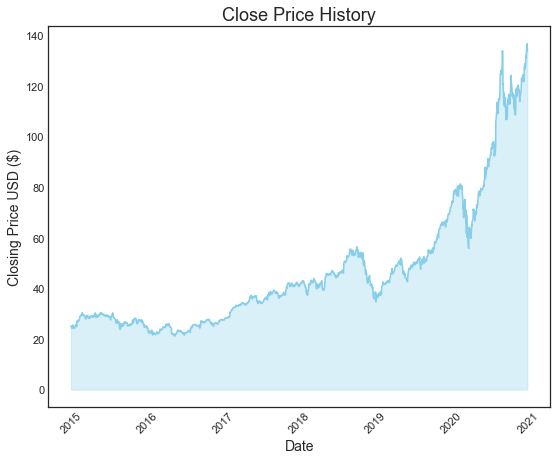

In [7]:
# Visualize the closing price history

f, ax = plt.subplots(figsize=(9, 7))
plt.fill_between(df2['Date'], df2['Close'], color='skyblue', alpha=0.3)
plt.plot(df2['Date'], df2['Close'], color='skyblue', alpha=1)
plt.xticks(rotation=45)
plt.title('Close Price History', fontsize=18)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Closing Price USD ($)", fontsize=14)

### Data Pre-processing

In [8]:
# Create a new data frame to keep only AAPL closing price using the 'Close' column
data = pd.DataFrame(sp500['AAPL']['Close'])

# Converting the dataframe to a numpy array
dataset = data.values

# Create the training data set by getting the number of rows to train the model on. Recommended is at least 80% of original set.
training_data_length = math.ceil( len(dataset) *.8) #use math.ceil to round up

# Review data length
print(training_data_length)

1209


In [9]:
# Checking AAPL closing price until December 30, 2020
sp500['AAPL']['Close']

Date
2014-12-31     25.137676
2015-01-02     24.898552
2015-01-05     24.197117
2015-01-06     24.199400
2015-01-07     24.538729
                 ...    
2020-12-23    130.960007
2020-12-24    131.970001
2020-12-28    136.690002
2020-12-29    134.869995
2020-12-30    133.720001
Name: Close, Length: 1511, dtype: float64

In [10]:
# Scale the all of the data to be values between 0 and 1 inclusive. Scaling is recommended when working with neural networks.
# Here, we used Data Normalization to accurately estimate min and max values - to stabilize sensitivity and weights of values.

scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.03437984],
       [0.03230993],
       [0.02623816],
       ...,
       [1.        ],
       [0.98424564],
       [0.97429105]])

In [11]:
# Create training data set where the past 60 days closing prices values will be used to predict 61st closing price value.

#Create the scaled training data set (all data from 0 to training_data_length; then next argument means get all columns)
train_data = scaled_data[0:training_data_length , : ]

#Split the data into x_train and y_train datasets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0]) #append past 60 days; contains 60 values from index 0 to 59
    y_train.append(train_data[i, 0]) #contains the 61st value which is at index 60


In [12]:
# Convert x_train and y_train to numpy arrays for use in training the LSTM model
x_train, y_train = np.array(x_train), np.array(y_train)

In [13]:
# Get the shape of x_train
x_train.shape

(1149, 60)

In [14]:
# Reshape the data into the shape accepted by the LSTM (3-dimensional - # of samples, time steps, features)
# x_train = np.reshape(x_train, (num of samples, 60, 1)) num of samples, 60 days, 1 feature which is the closing price
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1149, 60, 1)

### Build the Model

In [15]:
#Build the LSTM model to have two LSTM layers with 50 neurons and two Dense layers, one with 25 neurons and the other with 1 neuron.

model = Sequential()

# First LSTM Layer
model.add(LSTM(units=50, return_sequences=True, input_shape = (x_train.shape[1], 1))) 

# Second LSTM Layer
model.add(LSTM(units=50, return_sequences=False))

# Third layer 
model.add(Dense(units=25))

# Last layer 
model.add(Dense(units=1))

In [16]:
# Compile the model using the mean squared error (MSE) loss function and the adam optimizer
model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
# Train the Model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1149/1149 [==============================] - 21s 19ms/step - loss: 3.3976e-04


### Model Testing

In [18]:
#Create a testing dataset
test_data = scaled_data[training_data_length - 60: , : ] #training_data_len minus 60 to the end of the dataset, and get all columns

#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_length : , : ] # y_test will be all of the values that we want our model to predict; actual test values; not scaled

for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0]) # Past 60 prices
    

In [19]:
# Convert test data set (x_test) to a numpy array so we can use for testing the LSTM model
x_test = np.array(x_test)

# Check test data set shape
print(x_test)

[[0.25947774 0.26361184 0.26169396 ... 0.31812402 0.32007057 0.32248779]
 [0.26361184 0.26169396 0.27077208 ... 0.32007057 0.32248779 0.33125809]
 [0.26169396 0.27077208 0.26094812 ... 0.32248779 0.33125809 0.33008162]
 ...
 [0.82600032 0.79342258 0.82349431 ... 0.95836366 0.95039996 0.95914269]
 [0.79342258 0.82349431 0.7946324  ... 0.95039996 0.95914269 1.        ]
 [0.82349431 0.7946324  0.81122371 ... 0.95914269 1.         0.98424564]]


In [20]:
# Reshape the data into the shape accepted by the LSTM (3-dimensional - # of samples, time steps, features)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test

array([[[0.25947774],
        [0.26361184],
        [0.26169396],
        ...,
        [0.31812402],
        [0.32007057],
        [0.32248779]],

       [[0.26361184],
        [0.26169396],
        [0.27077208],
        ...,
        [0.32007057],
        [0.32248779],
        [0.33125809]],

       [[0.26169396],
        [0.27077208],
        [0.26094812],
        ...,
        [0.32248779],
        [0.33125809],
        [0.33008162]],

       ...,

       [[0.82600032],
        [0.79342258],
        [0.82349431],
        ...,
        [0.95836366],
        [0.95039996],
        [0.95914269]],

       [[0.79342258],
        [0.82349431],
        [0.7946324 ],
        ...,
        [0.95039996],
        [0.95914269],
        [1.        ]],

       [[0.82349431],
        [0.7946324 ],
        [0.81122371],
        ...,
        [0.95914269],
        [1.        ],
        [0.98424564]]])

In [21]:
# Get the shape of x_test
x_test.shape

(302, 60, 1)

In [22]:
y_test.shape

(302, 1)

### Validate the Model

In [23]:
# Get the models predicted price values
predictions = model.predict(x_test)

# Get inverse shape of data to undo scaling
predictions = scaler.inverse_transform(predictions)


In [24]:
#View results 
predictions

array([[ 55.625328],
       [ 55.92683 ],
       [ 56.21474 ],
       [ 56.549053],
       [ 56.882854],
       [ 57.259327],
       [ 57.68306 ],
       [ 57.93618 ],
       [ 58.068607],
       [ 58.263096],
       [ 58.653854],
       [ 59.153522],
       [ 59.650433],
       [ 60.09591 ],
       [ 60.54291 ],
       [ 60.960243],
       [ 61.370243],
       [ 61.72487 ],
       [ 62.076588],
       [ 62.339314],
       [ 62.60695 ],
       [ 62.881725],
       [ 63.108624],
       [ 63.203083],
       [ 63.18376 ],
       [ 63.096996],
       [ 63.101917],
       [ 63.09955 ],
       [ 63.187412],
       [ 63.29828 ],
       [ 63.3291  ],
       [ 63.189823],
       [ 63.033184],
       [ 62.98285 ],
       [ 63.12975 ],
       [ 63.268463],
       [ 63.431175],
       [ 63.649303],
       [ 63.892082],
       [ 64.21958 ],
       [ 64.68119 ],
       [ 65.180016],
       [ 65.62842 ],
       [ 66.0086  ],
       [ 66.29469 ],
       [ 66.617836],
       [ 66.930855],
       [ 67.3

### Performance Metrics

In [25]:
#Create function to generate performance metrics

def measure_performance(actual,predicted):
    r2 = r2_score(actual, predicted)
    mae = mean_absolute_error(actual, predicted) 
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    
    print(("r2: %.2f") %r2)
    print(("mae: %.2f") %mae)
    print(("rmse: %.2f") %rmse)

In [26]:
#Measure the performance of the model
measure_performance(y_test,predictions)

r2: 0.90
mae: 6.03
rmse: 7.14


### Visualize the data

<ipython-input-27-c108c7e4855d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_price['Predictions'] = predictions


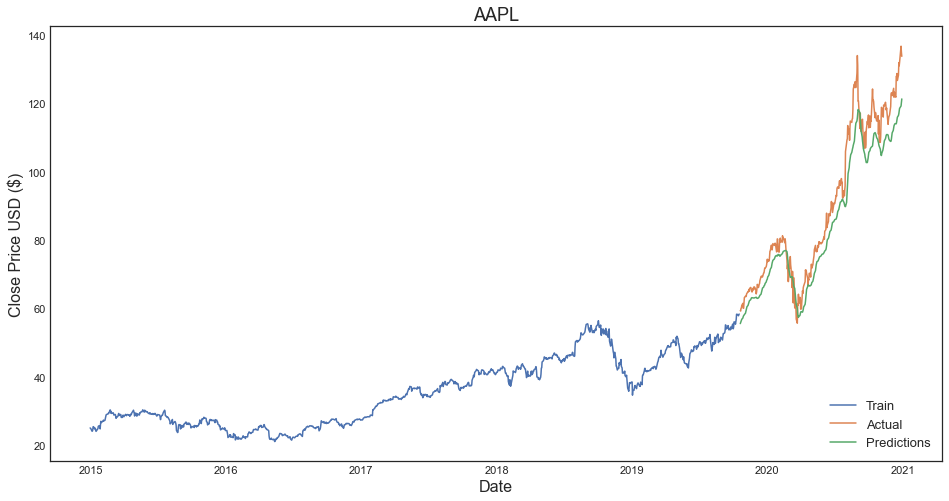

In [27]:
# Plot/Create the data for the graph
train = data[:training_data_length]
actual_price = data[training_data_length:]
actual_price['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,8))
plt.title('AAPL', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price USD ($)', fontsize=16)
plt.plot(train['Close'])
plt.plot(actual_price[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right', fontsize=13)
plt.show()

In [28]:
# Show the actual prices with the added column for predicted prices
actual_price.tail(10)

,Close,Predictions
Date,,
2020-12-16,127.809998,114.476952
2020-12-17,128.699997,115.142868
2020-12-18,126.660004,115.919846
2020-12-21,128.229996,116.453781
2020-12-22,131.880005,116.966194
2020-12-23,130.960007,117.762947
2020-12-24,131.970001,118.501060
2020-12-28,136.690002,119.227394
2020-12-29,134.869995,120.325470


### Get Closing Price prediction for December 31, 2020

In [29]:
# Get the quote
apple_quote = pd.DataFrame(sp500['AAPL'])

# Create a new dataframe
new_df = apple_quote.filter(['Close'])

# Get the last 60 day closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values

# Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)

# Create an empty list
X_test = []

# Append the past 60 days
X_test.append(last_60_days_scaled)

# Convert the X_test dataset to a numpy array
X_test = np.array(X_test)

# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price
pred_price = model.predict(X_test)

# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)

# Print the predicted closing price
print('Predicted price for 2020-12-31: ' + str(pred_price)[2:-2])

Predicted price for 2020-12-31: 121.936935


In [30]:
# Confirm the actual Close price
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start = '2020-12-01', end = '2020-12-31')
print(apple_quote2['Close'])

Date
2020-11-30    119.050003
2020-12-01    122.720001
2020-12-02    123.080002
2020-12-03    122.940002
2020-12-04    122.250000
2020-12-07    123.750000
2020-12-08    124.379997
2020-12-09    121.779999
2020-12-10    123.239998
2020-12-11    122.410004
2020-12-14    121.779999
2020-12-15    127.879997
2020-12-16    127.809998
2020-12-17    128.699997
2020-12-18    126.660004
2020-12-21    128.229996
2020-12-22    131.880005
2020-12-23    130.960007
2020-12-24    131.970001
2020-12-28    136.690002
2020-12-29    134.869995
2020-12-30    133.720001
2020-12-31    132.690002
Name: Close, dtype: float64
